In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体及图表清晰度
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300

# 加载数据集
df = pd.read_csv('nigerian-songs.csv')

print('数据基本信息：')
df.info()
print('\n数据预览：')
df.head()

数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              530 non-null    object 
 1   album             530 non-null    object 
 2   artist            530 non-null    object 
 3   artist_top_genre  530 non-null    object 
 4   release_date      530 non-null    int64  
 5   length            530 non-null    int64  
 6   popularity        530 non-null    int64  
 7   danceability      530 non-null    float64
 8   acousticness      530 non-null    float64
 9   energy            530 non-null    float64
 10  instrumentalness  530 non-null    float64
 11  liveness          530 non-null    float64
 12  loudness          530 non-null    float64
 13  speechiness       530 non-null    float64
 14  tempo             530 non-null    float64
 15  time_signature    530 non-null    int64  
dtypes: float64(8), int64(4), object(4)
m

,name,album,artist,artist_top_genre,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,Sparky,Mandy & The Jungle,Cruel Santino,alternative r&b,2019,144000,48,0.666,0.8510,0.420,0.534000,0.1100,-6.699,0.0829,133.015,5
1,shuga rush,EVERYTHING YOU HEARD IS TRUE,Odunsi (The Engine),afropop,2020,89488,30,0.710,0.0822,0.683,0.000169,0.1010,-5.640,0.3600,129.993,3
2,LITT!,LITT!,AYLØ,indie r&b,2018,207758,40,0.836,0.2720,0.564,0.000537,0.1100,-7.127,0.0424,130.005,4
3,Confident / Feeling Cool,Enjoy Your Life,Lady Donli,nigerian pop,2019,175135,14,0.894,0.7980,0.611,0.000187,0.0964,-4.961,0.1130,111.087,4
4,wanted you,rare.,Odunsi (The Engine),afropop,2018,152049,25,0.702,0.1160,0.833,0.910000,0.3480,-6.044,0.0447,105.115,4



最优簇数k（轮廓系数法）: 5


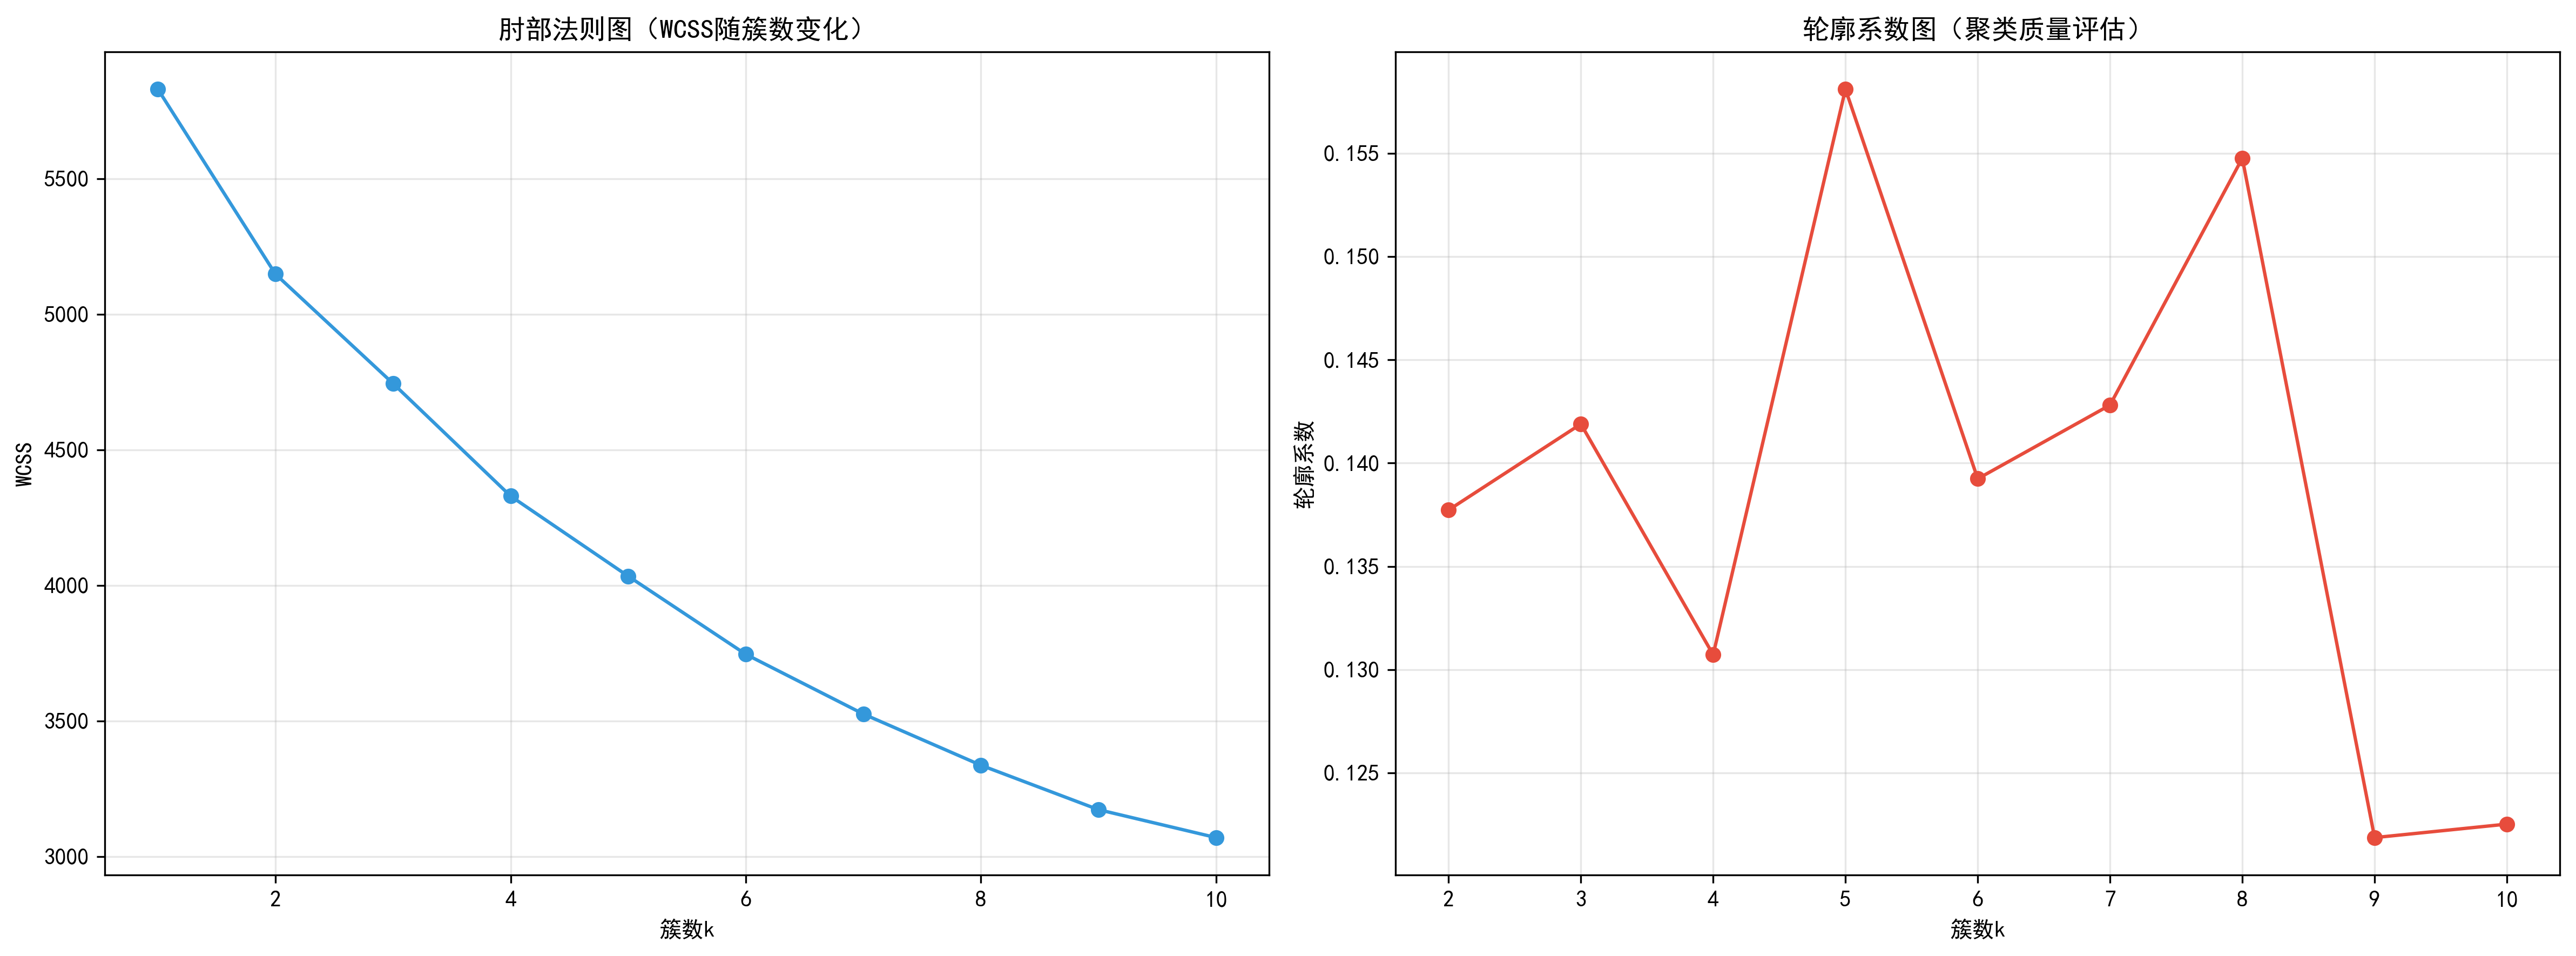

In [3]:
# 选取参与分析的特征
features = ['length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 
            'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature']

# 数据标准化
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[features])

# 1. 肘部法则图与轮廓系数法确定最佳簇数
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_df)
    score = silhouette_score(scaled_df, labels)
    silhouette_scores.append(score)

best_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f'\n最优簇数k（轮廓系数法）: {best_k}')

# 可视化最佳簇数选择
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), wcss, 'o-', color='#3498db')
plt.title('肘部法则图（WCSS随簇数变化）')
plt.xlabel('簇数k')
plt.ylabel('WCSS')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'o-', color='#e74c3c')
plt.title('轮廓系数图（聚类质量评估）')
plt.xlabel('簇数k')
plt.ylabel('轮廓系数')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 2. 多模型训练与评估
models = {
    'K-Means': KMeans(n_clusters=best_k, random_state=42),
    '层次聚类': AgglomerativeClustering(n_clusters=best_k),
    '谱聚类': SpectralClustering(n_clusters=best_k, random_state=42)
}

results = {}
for name, model in models.items():
    labels = model.fit_predict(scaled_df)
    
    # 确保至少有两个簇进行评估
    if len(np.unique(labels)) < 2:
        print(f"\n{name} 聚类结果簇数不足，无法计算评估指标")
        continue
        
    # 计算评估指标
    silhouette = silhouette_score(scaled_df, labels)
    ch_score = calinski_harabasz_score(scaled_df, labels)
    db_score = davies_bouldin_score(scaled_df, labels)
    
    results[name] = {
        'labels': labels,
        'silhouette': silhouette,
        'calinski_harabasz': ch_score,
        'davies_bouldin': db_score,
        'n_clusters': len(np.unique(labels))
    }

# 模型性能比较
metrics_df = pd.DataFrame({
    '模型': list(results.keys()),
    '轮廓系数': [results[name]['silhouette'] for name in results],
    'Calinski-Harabasz指数': [results[name]['calinski_harabasz'] for name in results],
    'Davies-Bouldin指数': [results[name]['davies_bouldin'] for name in results],
    '簇数量': [results[name]['n_clusters'] for name in results]
})

print("\n不同聚类模型性能比较：")
print(metrics_df)

In [ ]:
# 3. 聚类结果可视化
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_df)

# 模型聚类结果对比
plt.figure(figsize=(18, 6))
n_models = len(results)
for i, (name, result) in enumerate(results.items()):
    ax = plt.subplot(1, n_models, i+1)
    labels = result['labels']
    unique_labels = np.unique(labels)
    
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(unique_labels)))
    for j, label in enumerate(unique_labels):
        ax.scatter(
            reduced_data[labels == label, 0], 
            reduced_data[labels == label, 1], 
            c=[colors[j]], 
            label=f'簇 {label}',
            s=40, 
            alpha=0.8
        )
    
    ax.set_title(f'{name} 聚类结果')
    ax.set_xlabel('PCA维度1')
    ax.set_ylabel('PCA维度2')
    ax.legend(loc='best', bbox_to_anchor=(1, 0.5), frameon=False)
    ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()

# 评估指标对比可视化
plt.figure(figsize=(18, 6))
colors = ['#3498db', '#2ecc71', '#9b59b6']

plt.subplot(1, 3, 1)
sns.barplot(x='模型', y='轮廓系数', data=metrics_df, palette=colors)
plt.title('轮廓系数比较（越高表示聚类质量越好）')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 2)
sns.barplot(x='模型', y='Calinski-Harabasz指数', data=metrics_df, palette=colors)
plt.title('簇间分离度比较（越高表示簇间差异越大）')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 3)
sns.barplot(x='模型', y='Davies-Bouldin指数', data=metrics_df, palette=colors)
plt.title('簇内紧凑度比较（越低表示簇内越紧凑）')
plt.ylim(0, 5)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 4. K-Means特征深度分析
best_model = 'K-Means'
best_labels = results[best_model]['labels']
df['cluster'] = best_labels

# 计算簇特征均值
cluster_features = df.groupby('cluster')[features].mean()

# 特征箱线图：各簇特征分布
plt.figure(figsize=(18, 12))
for i, feature in enumerate(features):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x='cluster', y=feature, data=df, palette='pastel')
    plt.title(f'簇间{feature}分布对比')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

# 特征热图
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_features, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('各簇特征均值热图（标准化后）')
plt.tight_layout()
plt.show()

# 流行度相关性分析
correlation = df[features].corr()['popularity'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.values, y=correlation.index, palette='viridis')
plt.title('音频特征与流行度的相关性')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 5. 音乐类型分析
# 各簇音乐类型分布
cluster_genre = df.groupby('cluster')['artist_top_genre'].value_counts(normalize=True).unstack(fill_value=0)

# 堆叠柱状图展示音乐类型比例
plt.figure(figsize=(16, 10))
ax = cluster_genre.plot(kind='bar', stacked=True, colormap='Set3', edgecolor='none')
plt.title('各簇音乐类型分布比例')
plt.xlabel('簇编号')
plt.ylabel('类型占比')
plt.legend(title='音乐类型', bbox_to_anchor=(1, 0.5), frameon=False)
plt.grid(axis='y', alpha=0.3)

# 添加数据标签
for p in ax.patches:
    height = p.get_height()
    if height > 0.01:  # 只显示占比>1%的标签
        ax.text(p.get_x() + p.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# 6. 流行度与主要特征的散点图矩阵
key_features = ['danceability', 'energy', 'loudness', 'tempo', 'popularity']
sns.pairplot(df[key_features], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('流行度与关键音频特征的关系分析', y=1.02, fontsize=15)
plt.tight_layout()
plt.show()